In [6]:
import skimage.io as io
import skimage.color as color
import skimage.morphology as morphology
import skimage.feature as feature
import skimage.measure as measure
import numpy as np
import math
from math import sqrt, atan, degrees
from operator import itemgetter, attrgetter
import os
import tensorflow as tf
import keras
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def find_longest_line(plate_img_gr):
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(plate_img_gr, (kernel_size, kernel_size), 0)

    low_threshold = 150
    high_threshold = 200

    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 5  # maximum gap in pixels between connectable line segments
    line_image = np.copy(img) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    lls = []
    for indx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
            line_length = sqrt((x2-x1)**2 + (y2-y1)**2)
            lls.append((indx,line_length))
    lls.sort(key = lambda x: x[1])
    linessorted = []
    for (indx,ll) in lls:
        linessorted.append(lines[indx])
    return linessorted

def find_line_angle(line):
    x1,y1,x2,y2 = line[0]
    angle = degrees(atan(((y2-y1)/(x2-x1))))
    return angle

def rotate_image(plate_img_gr, angle):
    (h, w) = plate_img_gr.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(plate_img_gr, M, (w, h))
    return rotated

def adjust_cropping(rotated_img):
    h,w = rotated_img.shape
    targ_h = int(w/4)
    crop_h = int((h - targ_h)/2)
    cropped_rotated_img = rotated_img[crop_h:h-crop_h,:]
    return cropped_rotated_img

In [9]:
#load YOLO model to find car plate
# installing package to work with yolov8
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from ultralytics import YOLO

yolo_model = YOLO("/content/drive/MyDrive/best.pt")  # load a pretrained model

In [79]:
image_path="/content/drive/MyDrive/tiba_1.jpg"

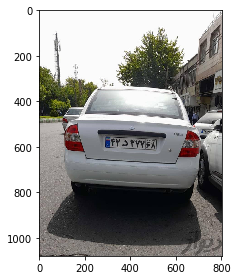

In [80]:
img=io.imread(image_path)
io.imshow(img)

In [81]:
!yolo task=detect mode=predict model="/content/drive/MyDrive/best.pt" conf=0.25 source="/content/drive/MyDrive/car-license-plate- (1).jpg" save=True

Ultralytics YOLOv8.0.38 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/drive/MyDrive/car-license-plate- (1).jpg: 384x512 3 vehicle plates, 68.2ms
Speed: 0.8ms pre-process, 68.2ms inference, 9.0ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict6



image 1/1 /content/drive/MyDrive/tiba_1.jpg: 512x384 1 vehicle plate, 20.8ms
Speed: 0.8ms pre-process, 20.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


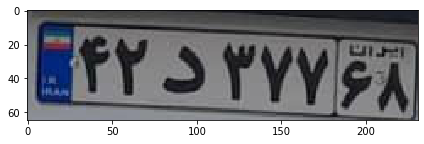

In [82]:
results = yolo_model.predict(source=image_path, conf=0.25)
x1,y1,x2,y2=results[0].boxes.xyxy[0]
roi=img[int(y1):int(y2),int(x1):int(x2)]
io.imshow(roi)

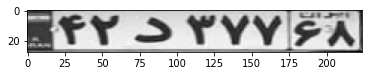

In [83]:
from skimage.color import rgb2gray

roi_gray=rgb2gray(roi)
linessorted = find_longest_line(roi)
rot_angle = find_line_angle(linessorted[-1])
rotated_img = rotate_image(roi_gray, rot_angle)
cropped_rotated_img = adjust_cropping(rotated_img)
cw = cropped_rotated_img.shape[1]
cropped_rotated_roi=cv2.resize(cropped_rotated_img[10:,10:],(224,28))

plt.imshow(cropped_rotated_roi,cmap="gray")
plt.show()

In [19]:
class_names = subdirs =['1','2', '3', '4','5','6','7','8','9','A','B','C','D','E','G','H','J','L','M','N','S','T','V','Y']
num_classes = len(class_names)
ocr_model = tf.keras.models.load_model('/content/drive/MyDrive/last_simple_ocr_plates_model.hdf5')

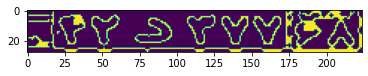

In [88]:
from skimage import filters
img2 = filters.gaussian(cropped_rotated_roi, sigma=1)
img3 = feature.canny(img2, sigma=1)
img4 = morphology.closing(img3)
plt.imshow(img4)
plt.show()

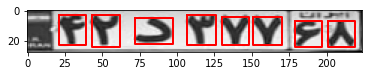

In [94]:
label_img = measure.label(img3)
regions = measure.regionprops(label_img)
fig, ax = plt.subplots()
ax.imshow(cropped_rotated_roi, cmap="gray")

def in_bboxes(bbox, bboxes):
    for bb in bboxes:
        minr0, minc0, maxr0, maxc0 = bb
        minr1, minc1, maxr1, maxc1 = bbox
        if minr1 >= minr0 and maxr1 <= maxr0 and minc1 >= minc0 and maxc1 <= maxc0:
            return True
    return False
def getArea(bbox):
  return (bbox[2]-bbox[0])* (bbox[3]-bbox[1])
bboxes = []
for props in regions:
    y0, x0 = props.centroid
    minr, minc, maxr, maxc = props.bbox
    
    if maxc - minc > img4.shape[1] / 7 or maxr - minr < img4.shape[0] / 3:
        continue
        
    bbox = [minr, minc, maxr, maxc]
    
    if in_bboxes(bbox, bboxes):
        continue
        
    if abs(y0 - img4.shape[0] / 2) > img4.shape[0] / 4:
        continue
    if getArea(bbox)<80 or getArea(bbox)>500 :  
        continue
    bboxes.append(bbox)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2)

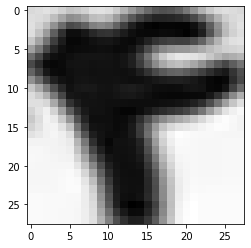

1/1 [==============================] - 0s 24ms/step
4


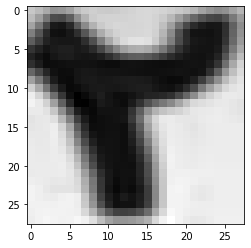

1/1 [==============================] - 0s 20ms/step
2


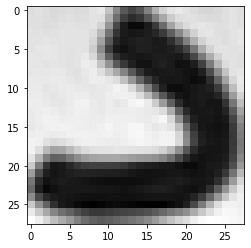

1/1 [==============================] - 0s 20ms/step
D


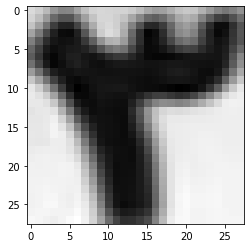

1/1 [==============================] - 0s 20ms/step
3


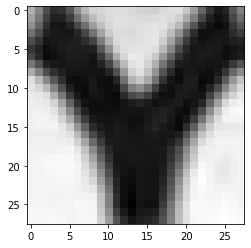

1/1 [==============================] - 0s 21ms/step
7


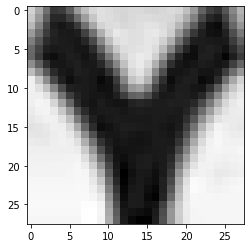

1/1 [==============================] - 0s 19ms/step
7


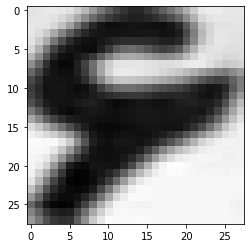

1/1 [==============================] - 0s 25ms/step
6


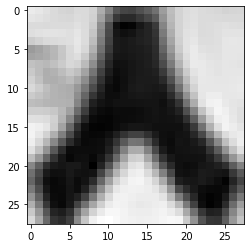

1/1 [==============================] - 0s 22ms/step
8


In [95]:
bboxes=sorted(bboxes,key=itemgetter(1))
for ch in bboxes:
  #cropped_rotated_roi_array=np.array(cropped_rotated_roi)
  char=cropped_rotated_roi[ch[0]:ch[2],ch[1]:ch[3]]
  char=cv2.resize(char, (28,28))
  plt.imshow(char,cmap="gray")
  plt.show()
  char = np.expand_dims(char, axis=0)
  predictions = ocr_model.predict(char)
  print(class_names[np.argmax(predictions[0])])